In [ ]:
import sys
sys.path.insert(0, "/Users/rboldi/repositories/pyribs")  # Adjust if needed

import numpy as np
import torch
from PIL import Image
from tqdm import tqdm

# Pyribs
from ribs.archives import DNSArchive
from ribs.schedulers import Scheduler
from ribs.emitters import GaussianEmitter

# Diffusion & CLIP
from diffusers import StableDiffusionPipeline
import clip

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === CONFIG ===
TARGET_PROMPT = "a cyberpunk cat wearing neon goggles, digital art"
LATENT_DIM = 128  # Reduced dimension for efficiency
POP_CAPACITY = 50
K_NEIGHBORS = 10
BATCH_SIZE = 20
EVAL_BUDGET = 500
SEED = 42

rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# === Load Models ===
print("Loading CLIP...")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

print("Loading Stable Diffusion (may take time)...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None,  # Disable for research
    requires_safety_checker=False,
)
pipe = pipe.to(device)
pipe.set_progress_bar_config(disable=True)  # Silence diffusers progress

# Get original CLIP embedding of target prompt
with torch.no_grad():
    target_tokens = clip.tokenize([TARGET_PROMPT]).to(device)
    target_clip_text_emb = clip_model.encode_text(target_tokens).float()  # (1, 512)
    target_clip_text_emb /= target_clip_text_emb.norm(dim=-1, keepdim=True)

# === Learnable projection: 128D -> 512D (frozen after init) ===
projection = torch.nn.Linear(LATENT_DIM, 768, bias=False).to(device)
torch.nn.init.xavier_uniform_(projection.weight)
projection.eval()  # Keep frozen during evolution

@torch.no_grad()
def evaluate_latents(latents: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    N = latents.shape[0]
    latents = torch.from_numpy(latents).float().to(device)  # (N, d)
    text_emb_768 = projection(latents)  # (N, 768)
    text_emb_768 = text_emb_768.unsqueeze(1)  # (N, 1, 768)

    # Compute negative prompt embeddings for empty string (batch size N)
    uncond_tokens = [""] * N
    uncond_input = pipe.tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,  # 77
        truncation=True,
        return_tensors="pt",
    ).to(device)
    negative_prompt_embeds = pipe.text_encoder(uncond_input.input_ids)[0]  # (N, 77, 768)

    # Pad your prompt_embeds to 77 tokens manually or via expansion
    # Simple method: repeat your (N,1,768) to (N,77,768)
    prompt_embeds = text_emb_768.expand(-1, 77, -1)  # (N, 77, 768)

    # Generate images
    images_pil = pipe(
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
        num_images_per_prompt=1,
        guidance_scale=7.5,
        num_inference_steps=5,
        output_type="pil"
    ).images

    # ... rest unchanged (CLIP scoring)
    images_clip = torch.stack([clip_preprocess(img) for img in images_pil]).to(device)
    img_embs = clip_model.encode_image(images_clip).float()
    img_embs /= img_embs.norm(dim=-1, keepdim=True)
    similarities = (img_embs @ target_clip_text_emb.T).squeeze(-1)
    objectives = (similarities * 100).cpu().numpy()
    measures = img_embs.cpu().numpy()

    return objectives, measures

# === DNS Setup ===
print("Initializing DNS...")
dns_archive = DNSArchive(
    solution_dim=LATENT_DIM,
    measure_dim=512,  # CLIP image space
    capacity=POP_CAPACITY,
    k_neighbors=K_NEIGHBORS,
    seed=SEED,
)

from ribs.emitters import EmitterBase
import numpy as np

emitter = GaussianEmitter(dns_archive, x0=np.zeros(LATENT_DIM), batch_size=BATCH_SIZE, sigma=0.5, seed=SEED)
scheduler = Scheduler(dns_archive, [emitter])

# === Evolution Loop ===
print(f"Starting DNS evolution (budget: {EVAL_BUDGET})...")
evals = 0

# Initial population
init_sols = emitter.ask()
init_obj, init_meas = evaluate_latents(init_sols)
dns_archive.add(init_sols, init_obj, init_meas)
evals += len(init_sols)

pbar = tqdm(total=EVAL_BUDGET, initial=evals)
while evals < EVAL_BUDGET:
    sols = emitter.ask()
    objs, meas = evaluate_latents(sols)
    dns_archive.add(sols, objs, meas)
    evals += len(sols)
    pbar.update(len(sols))
    pbar.set_postfix({"QD": f"{dns_archive.stats.qd_score:.1f}"})

pbar.close()

# === Visualization & Results ===
print("\nFinal Archive Stats:")
print(f"Size: {len(dns_archive)}")
print(f"QD Score: {dns_archive.stats.qd_score:.2f}")
print(f"Coverage: {dns_archive.stats.coverage:.4f}")

# Save best image
best = dns_archive.best_elite
if best is not None:
    best_latent = torch.from_numpy(best["solution"]).float().unsqueeze(0).to(device)
    best_emb = projection(best_latent)
    best_emb /= best_emb.norm(dim=-1, keepdim=True)
    best_img = pipe(prompt_embeds=best_emb, num_inference_steps=30).images[0]
    best_img.save("best_dns_clip_evolved.png")
    print("Saved best image to 'best_dns_clip_evolved.png'")

/Users/rboldi/repositories/pyribs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rboldi/repositories/pyribs/.venv/lib/python3.12/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging


Using device: cpu
Loading CLIP...
Loading Stable Diffusion (may take time)...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 22.83it/s]


Initializing DNS...
Starting DNS evolution (budget: 500)...


 84%|████████▍ | 420/500 [5:37:57<1:25:43, 64.30s/it, QD=813.8] 

In [ ]:

# === Evaluation function that also returns images ===
@torch.no_grad()
def evaluate_latents_with_images(latents: np.ndarray):
    """Returns (objectives, measures, pil_images) for a batch of latents."""
    N = latents.shape[0]
    latents = torch.from_numpy(latents).float().to(device)
    prompt_emb = projection(latents)  # (N, 768)
    prompt_emb = prompt_emb.unsqueeze(1).expand(-1, 77, -1)  # (N, 77, 768)

    # Negative prompt embeddings (empty string)
    uncond = pipe.tokenizer(
        [""] * N,
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)
    negative_emb = pipe.text_encoder(uncond.input_ids)[0]  # (N, 77, 768)

    # Generate images
    output = pipe(
        prompt_embeds=prompt_emb,
        negative_prompt_embeds=negative_emb,
        guidance_scale=7.5,
        num_inference_steps=20,
        output_type="pil"
    )
    images_pil = output.images

    # CLIP scoring
    images_clip = torch.stack([clip_preprocess(img) for img in images_pil]).to(device)
    img_embs = clip_model.encode_image(images_clip).float()
    img_embs /= img_embs.norm(dim=-1, keepdim=True)
    similarities = (img_embs @ target_clip_text_emb.T).squeeze(-1)
    objectives = (similarities * 100).cpu().numpy()  # Scale to ~[0,100]
    measures = img_embs.cpu().numpy()  # (N, 512)

    return objectives, measures, images_pil

# === Show 10 random initial images with timing ===
print("\n" + "="*50)
print("Generating 10 random initial images...")
N_INIT = 2
init_latents = rng.normal(0, 1.0, size=(N_INIT, LATENT_DIM)).astype(np.float32)

all_obj, all_meas, all_images = [], [], []

for i in tqdm(range(N_INIT), desc="Init images", total=N_INIT):
    lat = init_latents[i:i+1]
    obj, meas, imgs = evaluate_latents_with_images(lat)
    all_obj.append(obj[0])
    all_meas.append(meas[0])
    all_images.append(imgs[0])

random_obj = np.array(all_obj)
random_meas = np.array(all_meas)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(all_images[i])
    ax.axis("off")
    obj_val = random_obj[i]
    meas_vals = random_meas[i, :2]
    ax.set_title(
        f"Obj: {obj_val:4.1f}\nMeas: [{meas_vals[0]:+.2f}, {meas_vals[1]:+.2f}]",
        fontsize=9
    )
plt.suptitle(f"Initial Random Generations — Target: '{TARGET_PROMPT}'", fontsize=12, y=0.98)
plt.tight_layout()
plt.show()


: 

IndexError: list index out of range

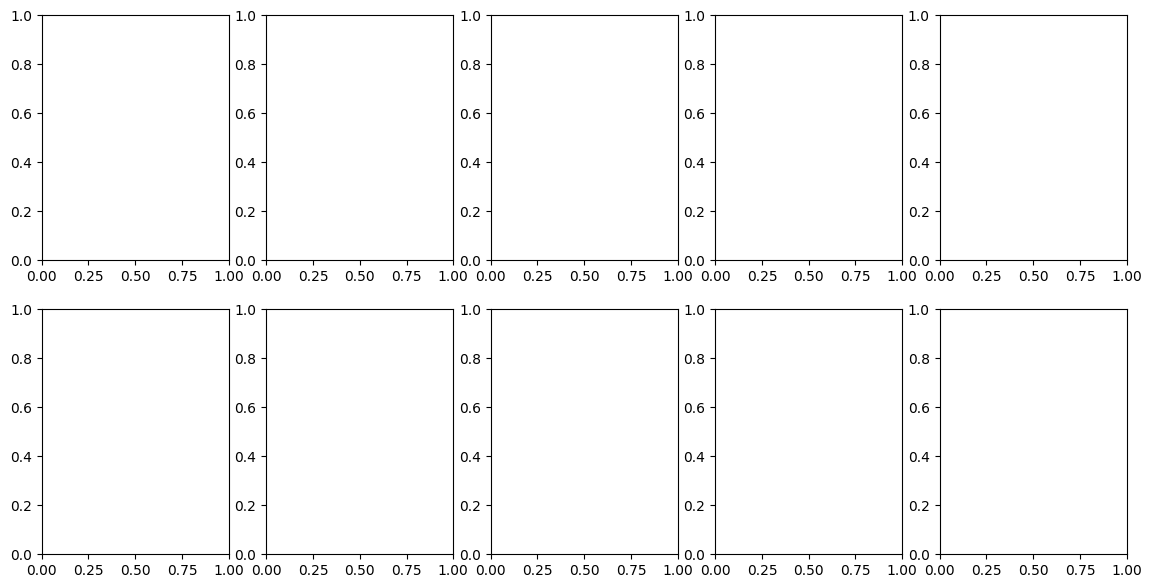

In [ ]:
import matplotlib.pyplot as plt


# Plot
fig, axes = plt.subplots(2, 5, figsize=(14, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(all_images[i])
    ax.axis("off")
    obj_val = random_obj[i]
    meas_vals = random_meas[i, :2]
    ax.set_title(
        f"Obj: {obj_val:4.1f}\nMeas: [{meas_vals[0]:+.2f}, {meas_vals[1]:+.2f}]",
        fontsize=9
    )
plt.suptitle(f"Initial Random Generations — Target: '{TARGET_PROMPT}'", fontsize=12, y=0.98)
plt.tight_layout()
plt.show()